In [1]:
import zipfile
from pathlib import Path

import altair as alt
import numpy as np
import pandas as pd
from loguru import logger

## Loading data from source zip

In [2]:
def load_from_zip():
    """
    load_from_zip reads a list of excel files from the source zip file into a 
    dictionary with the values are DataFrames from them.
    """
    dfs = {"fr": {}, "ar": {}}
    with zipfile.ZipFile("data-votes-lf.zip") as z:
        for f in z.filelist:
            file_path = Path(f.filename)
            if ".xlsx" in file_path.name:
                with z.open(file_path.as_posix()) as f:
                    # File names are of the format "votes-lf-2015-fr" 
                    # that's why I use split over "-" to extract only the year
                    # perhaps using regex is more sensible
                    key_name = file_path.stem.split("-")[2]
                    if "fr" in file_path.name:
                        dfs["fr"][key_name] = pd.read_excel(f)
                    else:
                        dfs["ar"][key_name] = pd.read_excel(f)
    return dfs

In [3]:
data = load_from_zip()

## Merging data into a single Data Frame

The strategy is to apply some transformations over each data frame and append the resulting **tidy data frame** to a list, which in turn is then merged into a single data frame. The transformations should be the same for all data frame, **although that should be tested**.

In [4]:
def tidy(df, year, is_comp):
    return (
        df.dropna(axis="columns", how="all")  # The data contains an empty column
        .melt(id_vars=["depute", "bloc"], var_name="loi", value_name="vote")
        .pipe(
            # year and is_comp used to track origin of dataframe
            lambda df: df.assign(year=int(year), is_comp=is_comp)
        )
    )

Tidying data in French

In [5]:
tidy_fr_dfs = []

In [6]:
for df in data["fr"]:
    year = df[:4]
    is_comp = df[-3:] == "bis"
    tidy_df = tidy(data["fr"][df], year, is_comp)
    tidy_fr_dfs.append(tidy_df)

In [7]:
tidy_fr = pd.concat(tidy_fr_dfs)

In [8]:
tidy_fr.sample(5)

,depute,bloc,loi,vote,year,is_comp
36984,Rim Mahjoub,Allégeance à la Patrie,Ajout d'article N°3 par le gouvernement,pour,2017,False
20667,Imen Ben Mhamed,Mouvement Ennahdha,Article 39 nouveau,X,2018,False
36933,Mohamed Frikha,Mouvement Ennahdha,Proposition N°29 d'ajout d'article,X,2016,False
21503,Faycel Khelifa,Mouvement Nidaa Tounes,Vote sur l’article 61 dans sa version initiale,pour,2019,False
2474,Meherzia Laabidi,Mouvement Ennahdha,Budget du ministère des affaires étrangères,X,2017,False


A simple safeguard test to check if the transofrmations occurred correctly. We expect the number of deputees across years and types of law *regular or complementary* to be 217.

In [9]:
tidy_fr.groupby(["year", "is_comp"]).nunique().pipe(
    lambda df: df.loc[df.depute != 217, "depute"]
).to_frame()

,,depute
year,is_comp,
2016,True,219
2017,True,216
2018,False,216


## Inconsistent number of MPs

To explore this issue, we need to see for each deputy (*or MP for member of parliment*) the years in which they have *at least voted once*. To achieve this, we pivot our data so that deputee names are the index, the columns are `year` and `is_comp`, and the value is the count of votes. Afterwards we simplify the data so that if a deputee has voted at least once in a year for a type of law (*is_comp*) they get 1, else it is 0.

In [10]:
is_mp_by_year = tidy_fr.pivot_table(
    index="depute",
    columns=["year", "is_comp"],
    values="vote",
    aggfunc="count",
    fill_value=0,
).pipe(lambda df: df.applymap(lambda x: 1 if x > 0 else 0))

In [11]:
is_mp_by_year.sample(5)

year           2015  2016        2017        2018  2019
is_comp       True  False True  False True  False False
depute                                                 
Mabrouk Hrizi     1     1     1     1     1     1     1
Hela Omrane       1     1     1     1     1     1     1
Ons Hattab        1     1     1     1     1     1     1
Lamia Gharbi      1     1     1     1     1     1     1
Imed Khemiri      1     1     1     1     1     1     1

### 2016 T

First, we investigate the issue of having 219 MPs in 2016 T.

In [12]:
is_mp_16 = is_mp_by_year[[(2016, True), (2016, False)]]

List of MPs who joined on 2016 T

In [13]:
is_mp_16.pipe(
    lambda df: df.loc[(df[(2016, False)] == 0) & (df[(2016, True)] == 1)]
).reset_index()["depute"].to_frame()

,depute
0,Abdelouahab Ouerfelli
1,Faten Oueslati
2,Heger Ben Cheikh Ahmed
3,Karima Taggaz
4,Lamia Dridi
5,Marouan Falfel
6,Mohamed Abdellaoui
7,Olfa Jouini


List of MPs who left on 2016 T

In [14]:
is_mp_16.pipe(
    lambda df: df.loc[(df[(2016, False)] == 1) & (df[(2016, True)] == 0)]
).reset_index()["depute"].to_frame()

,depute
0,Iyad Dahmani
1,Khaled Chouket
2,Mehdi Ben Gharbia
3,Mohsen Hssan
4,Riadh Mouakhar
5,Sayida Ounissi


### 2017 T

In [15]:
is_mp_17 = is_mp_by_year[[(2017, True), (2017, False)]]

List of MPs who joined on 2017 T

In [16]:
is_mp_17.pipe(
    lambda df: df.loc[(df[(2017, True)] == 1) & (df[(2017, False)] == 0),]
).reset_index()["depute"].to_frame()

,depute
0,Abdelouahab Ouerfelli
1,Amira Zoukari
2,Mohamed Abdellaoui


List of MPs who left on 2017 T

In [17]:
is_mp_17.pipe(
    lambda df: df.loc[(df[(2017, True)] == 0) & (df[(2017, False)] == 1),]
).reset_index()["depute"].to_frame()

,depute
0,Faten Oueslati
1,Hatem Ferjani
2,Salem Hamdi
3,Taher Battikh


## Plots

For these plot, the interest is only on the final vote, we filter the data frame for this law.

In [18]:
plot_df = tidy_fr.pipe(lambda df: df.loc[df.loi.str.contains("totalité"),]).drop(columns=["loi"])

In [19]:
plot_df.sample(5)

,depute,bloc,vote,year,is_comp
35782,Leila Hamrouni,Coalition nationale,pour,2019,False
40976,Abdelmoumen Belanes,Aucun bloc,contre,2017,False
1152,Haykel Belgacem,Aucun bloc,contre,2017,True
1260,Adnane Hajji,Allégeance à la Patrie,contre,2016,True
1146,Mohamed Anouar Adhar,Coalition nationale,pour,2016,True


### The vote distribution per finance law per block

In [20]:
vdb = (
    plot_df.pivot_table(
        index=["year", "is_comp", "bloc", "vote"], aggfunc="count", fill_value=0
    )
    .reset_index()
    .pipe(
        lambda df: df.assign(
            law=df.year.astype("str") + "-" + df.is_comp.astype("int").astype("str")
        )
    )
    .pipe(
        lambda df: pd.crosstab(
            index=[df["law"], df["bloc"]],
            columns=df["vote"],
            values=df["depute"],
            aggfunc="sum",
        )
        .fillna(0)
        .pipe(lambda df: df.apply(lambda df: np.round(100 * df / df.sum()), axis=1))
    )
    .reset_index()
    .melt(
        id_vars=["law", "bloc"],
        value_vars=["X", "pour", "contre", "abstenu"],
        value_name="percentage",
    )
)

In [21]:
vdb.sample(5)

,law,bloc,vote,percentage
144,2019-0,Coalition nationale,contre,0.0
7,2016-0,Allégeance à la Patrie,X,44.0
89,2018-0,Mouvement Ennahdha,pour,76.0
192,2019-0,Bloc Démocrate,abstenu,0.0
171,2017-0,Bloc Démocrate,abstenu,0.0


Testing that the sum of vote percentage per law per block is 100%

In [33]:
w = 1200
h = w / (16 / 9)

### Distribution of votes across finance laws

In [23]:
bars = (
    alt.Chart(vdb)
    .mark_bar()
    .encode(
        y=alt.Y("bloc"),
        x=alt.X("percentage"),
        color="vote",
        order="vote",
        tooltip=["bloc", "vote", "percentage"],
    )
)
text = (
    alt.Chart(vdb)
    .mark_text(color="white")
    .encode(
        y=alt.Y("bloc"),
        x=alt.X("percentage"),
        text=alt.Text("percentage", format=".1%",),
    )
)

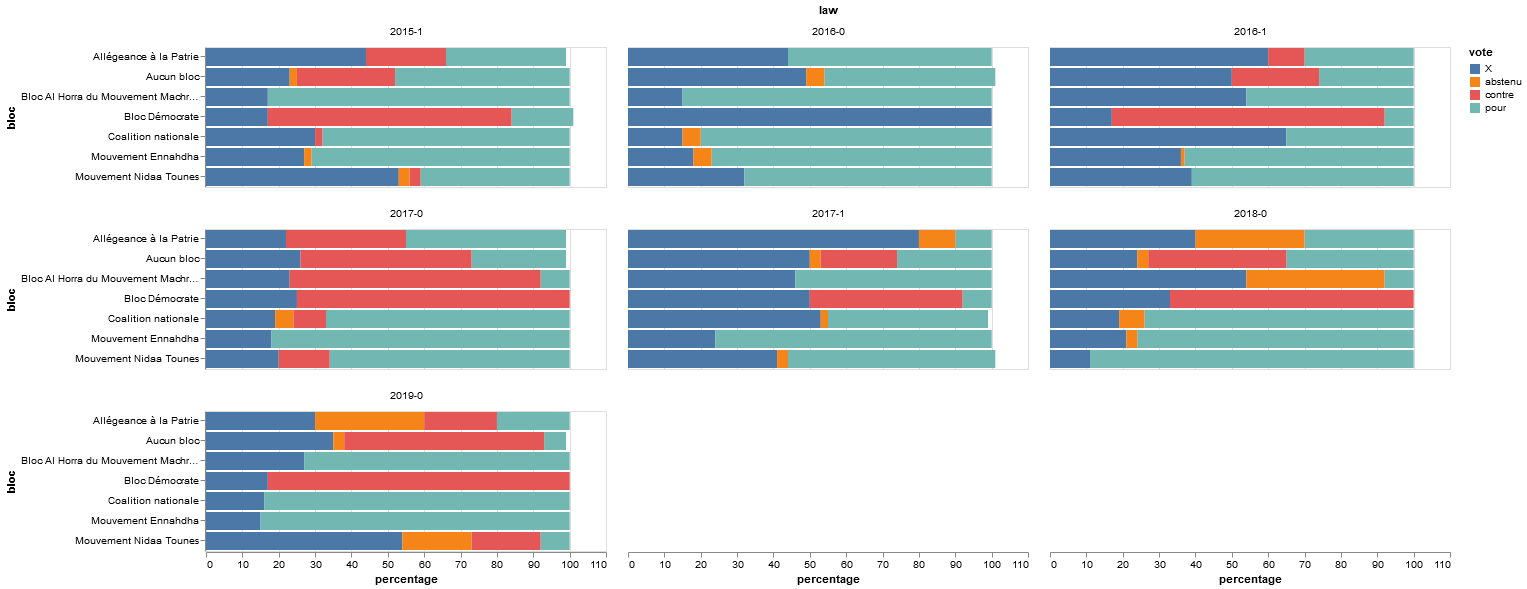

In [24]:
#alt.layer(bars, text).properties(width=w, height=h).facet("law", columns=3).display()
bars.facet("law", columns=3)

### Average votes for each block across finace laws

## Vote distribution by year by law

In [25]:
import plotly.express as px

In [26]:
vdb.sample(5)

,law,bloc,vote,percentage
179,2017-1,Coalition nationale,abstenu,2.0
68,2016-1,Mouvement Ennahdha,pour,63.0
58,2016-0,Bloc Al Horra du Mouvement Machrouu Tounes,pour,85.0
81,2017-1,Coalition nationale,pour,44.0
38,2018-0,Bloc Démocrate,X,33.0


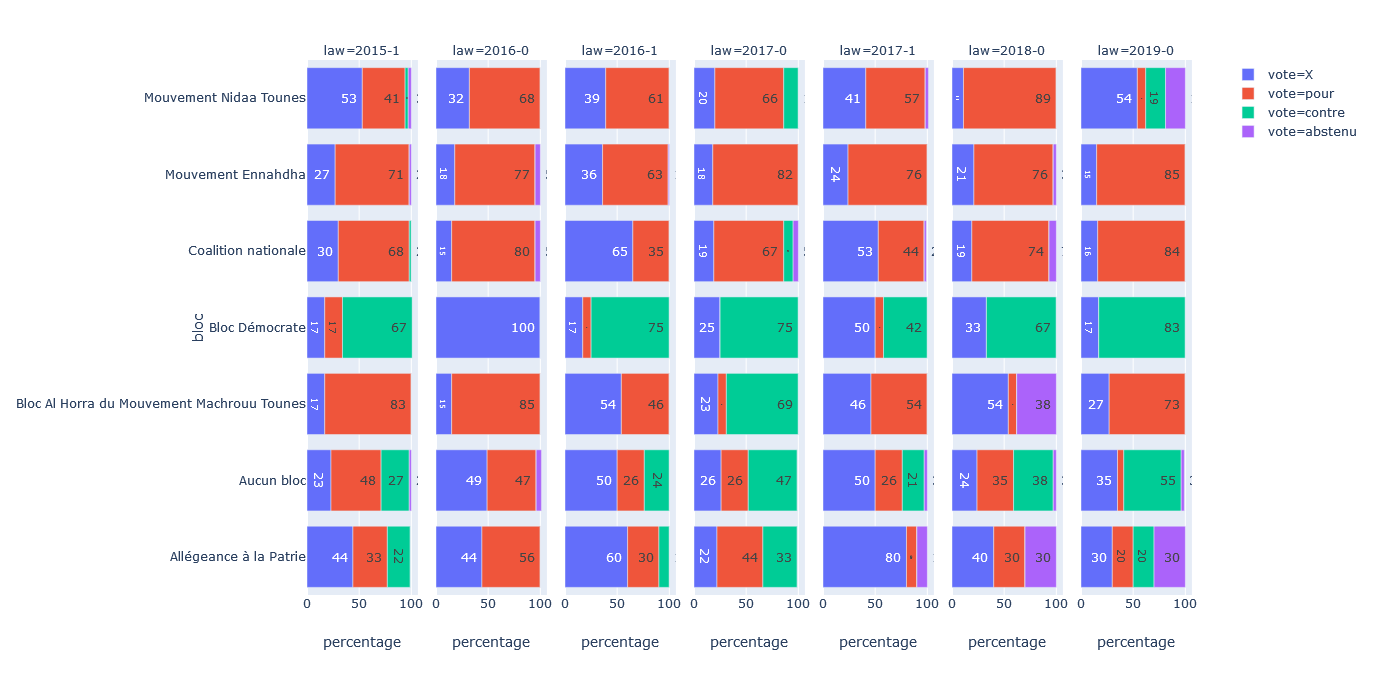

In [34]:
px.bar(vdb, y="bloc", x="percentage", facet_col="law", color="vote",  orientation="h", text="percentage", width=w, height=h)

## Table plot: vote per bloc per finance law

https://altair-viz.github.io/gallery/table_bubble_plot_github.html

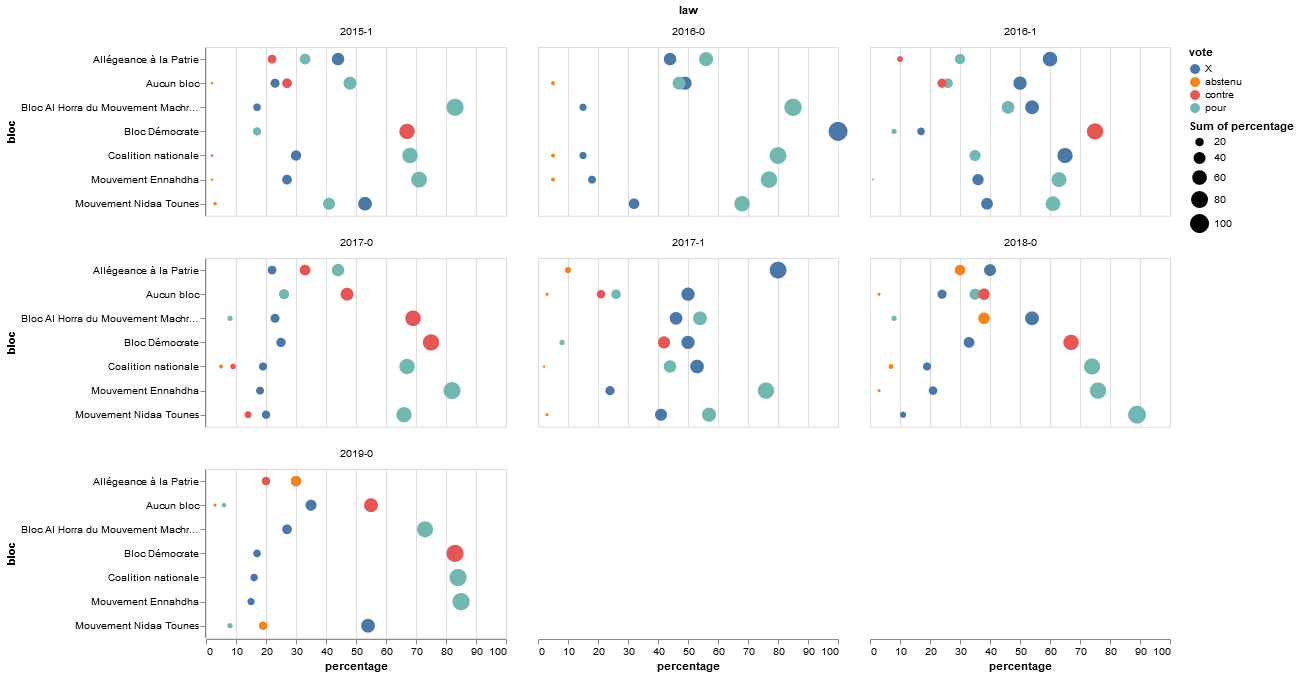

In [29]:
alt.Chart(vdb).mark_circle().encode(
    y="bloc",
    x="percentage",
    size="sum(percentage)",
    color="vote",
    tooltip=["bloc", "vote", "percentage"],
).properties(width=w, height=h).facet("law", columns=3)